Basic draftsim analysis (by Bobby Mills and Arseny Khakhalin)

Version Dec 15 2018

In [325]:
import pandas as pd
import numpy as np

import csv
import json

import re # Regular expressions

import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import time

from sklearn.manifold import MDS

Change the set abbrevation below to work with a different set:

In [385]:
# Alternatives: XLN, DOM, GRN, M19
setName = 'M19'

In [386]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)
    
jsonSubset = mtgJSON[setName]['cards']

if setName=='XLN':
    jsonSubset = jsonSubset+ mtgJSON['RIX']['cards']

In [387]:
def fixName(name):
    res = re.sub(' ', '_', name)
    res = re.sub(',_', '_', res)
    res = re.sub('_\d+', '', res) #remove _number from lands
    res = re.sub('_\([a-zA-Z]\)', '', res) #remove guildgate types
    res = res.lower()
    return res

In [379]:
def getName(card):
    s = '_'
    #names only occurs in split cards
    if card['layout'] == 'split':
        return s.join(
            [fixName(x) for x in card['names']]) #format split card names
    else: #else just use name
        return fixName(card['name'])

In [380]:
def isLegendary(card):
    return 'supertypes' in card.keys() and 'Legendary' in card['supertypes']

In [368]:
def getCardColor(card):
    colors = ['W', 'U', 'B', 'R', 'G'] # Change that to proper color sequence at some point (including in plots below)
    pattern = "[W,U,B,R,G]"
    
    if 'manaCost' in card.keys():
        mana = re.findall(pattern, card['manaCost'])
        mana = list(set(mana)) #delete duplicates
        if len(mana) == 0:
            return 0
        elif len(mana) > 1:
            return 1
        else:
            return colors.index(mana[0]) + 2
        return mana
    
    #for colored land cards
    elif 'colorIdentity' in card.keys():
        mana = card['colorIdentity']
        if len(mana) == 0:
            return 0
        elif len(mana) > 1:
            return 1
        else:
            return colors.index(mana[0]) + 2
        return mana
    #colorless lands
    else:
        return 0

In [388]:
thisSet = {getName(card) : card for card in jsonSubset} # dict with names as indices for cards, for all cards in set
dict((k.lower(), v) for k, v in thisSet.items())        # Lowercase the keys
cardlist = list(thisSet.keys())                         # List of card names (strings)

Change the addresses below if you store data ini a different folder locally:

In [389]:
dataFileName = {
    'XLN': '../2018-02-23 Two days data XLN.csv',
    'DOM': '../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../2018-10-05 GRN Draft Data 1.csv',
}

draftData = pd.read_csv(dataFileName[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
1559676,M19,"Leonin_Warleader,Take_Vengeance,Shield_Mare,Ma...","Goreclaw,_Terror_of_Qal_Sisma,Gravedigger,Ghir...","Death_Baron,Plague_Mare,Switcheroo,Macabre_Wal...","Luminous_Bonds,Departed_Deckhand,Skilled_Anima...","Vivien's_Invocation,Gravedigger,Druid_of_the_C...","Ajani's_Last_Stand,Knightly_Valor,Arcane_Encyc...","Murder,Aven_Wind_Mage,Psychic_Symbiont,Walking...","Dark-Dweller_Oracle,Rabid_Bite,Ghastbark_Twins..."
1559677,M19,"Sai,_Master_Thopterist,Snapping_Drake,Skyscann...","Vine_Mare,Lightning_Strike,Bristling_Boar,Plag...","Resplendent_Angel,Angel_of_the_Dawn,Angel_of_t...","Star-Crowned_Stag,Angel_of_the_Dawn,Lich's_Car...","Spit_Flame,Guttersnipe,Electrify,Goblin_Instig...","Sift,Electrify,Switcheroo,Suspicious_Bookcase,...","Bone_Dragon,Vampire_Neonate,Ravenous_Harpy,Sky...","Lathliss,_Dragon_Queen,Lich's_Caress,Trumpet_B..."
1559678,M19,"Valiant_Knight,Murder,Skymarch_Bloodletter,Peg...","Spit_Flame,Electrify,Shock,Rabid_Bite,Draconic...","Spit_Flame,Reassembling_Skeleton,Departed_Deck...","Goblin_Trashmaster,Dwindle,Hostile_Minotaur,Bo...","Open_the_Graves,Gallant_Cavalry,Poison-Tip_Arc...","Goreclaw,_Terror_of_Qal_Sisma,Oakenform,Aviati...","Ajani's_Pridemate,Electrify,Dragon_Egg,Arcane_...","Prodigious_Growth,Skyrider_Patrol,Meteor_Golem..."
1559680,M19,"Hieromancer's_Cage,Leonin_Vanguard,Luminous_Bo...","Ajani,_Adversary_of_Tyrants,Vivien's_Invocatio...","Demon_of_Catastrophes,Lightning_Strike,Skymarc...","Plague_Mare,Shock,Reassembling_Skeleton,Maraud...","Chromium,_the_Mutable,Militia_Bugler,Aethershi...","Hieromancer's_Cage,Heroic_Reinforcements,Aeria...","Departed_Deckhand,Lich's_Caress,Reassembling_S...","Lathliss,_Dragon_Queen,Electrify,Fiery_Finish,..."
1559682,M19,"Tezzeret,_Artifice_Master,Skilled_Animator,Lum...","Djinn_of_Wishes,Angel_of_the_Dawn,Aven_Wind_Ma...","Sarkhan's_Unsealing,Star-Crowned_Stag,Heroic_R...","Meteor_Golem,Luminous_Bonds,Fell_Specter,Rabid...","Demanding_Dragon,Pegasus_Courser,Arcane_Encycl...","Isareth_the_Awakener,Departed_Deckhand,Dwindle...","Goreclaw,_Terror_of_Qal_Sisma,Plague_Mare,Ghas...","Prodigious_Growth,Dryad_Greenseeker,Gargoyle_S..."


In [371]:
# If you want to see a full record for any single card
# next(iter(thisSet.values()))

In [390]:
# Prepare for the main loop: 
# Initialize all vars to collect data
# We use basic arrays rather than numpy as they are ~10% faster

cardpicks = {cardName : [] for cardName in cardlist} # Pick order
nCards = len(cardlist)
pairs = [[0 for i in range(nCards)] for j in range(nCards)]  # Cards that were drafted together
freq = [0]*nCards
guild = [[0 for i in range(5)] for j in range(5)]

Main loop (may take up to 10 minutes to run)

In [391]:
draftCount = 0
player = 'human' # normally should be: human, but can also be bot1 or another bot
ticTime = time.time()
for pile in draftData[player]:#[0:1000]:
    pile = fixName(pile)
    pile = pile.lower()
    pile = pile.split(',')
    
    draftCount = draftCount+1                 # For debugging
    colorCount = [0,0,0,0,0,0,0]
    for i in range(len(pile)):
        try:
            colorCount[getCardColor(thisSet[pile[i]])] += 1    # Count card colors within this pile only
            freq[cardlist.index(pile[i])] += 1                 # Total times this card was drafted
            
            for j in range(i):
                indi = cardlist.index(pile[i])
                indj = cardlist.index(pile[j])
                if indi>indj:
                    pairs[indi][indj] += 1                      # For now, only fill the left half of the matrix
                else:
                    pairs[indj][indi] += 1
            
            if i<14:
                cardpicks[pile[i]].append(i+1) # For ratings, we only look at the 1st booster as God knows what happens after
        
        except KeyError as e:
            print(pile)
            print(draftCount)
            raise

print("Time elapsed: ", time.time() - ticTime)

Time elapsed:  225.1458775997162


In [392]:
pairs = np.array(pairs)
freq = np.array(freq)
# plt.imshow(pairs, cmap="Greys")

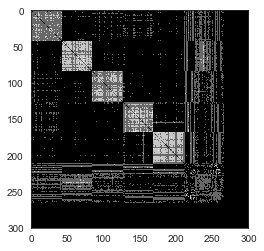

In [393]:
nDrafts = draftCount
prob = pairs*1           # Make a copy, and also make symmetric

for i in range(nCards):
    for j in range(i+1):
        if freq[i]*freq[j]>0:
            prob[i,j] = prob[i,j]/(freq[i]*freq[j])*nDrafts
            prob[j,i] = prob[i,j]
        
dist = (1-0.99*prob/prob.max())
plt.imshow(dist, cmap="Greys")

In [394]:
embedding = MDS(n_components=2, dissimilarity='precomputed', max_iter=1000, eps=0.001)
fit = embedding.fit_transform(dist)

In [395]:
# Debugging: a list of cards that weren't actually drafted
for i in range(nCards):
    if freq[i]==0:
        cardpicks[cardlist[i]].append(100) # Placeholder (they'll be deleted anyway)
        print(cardlist[i])

nicol_bolas_the_arisen
ajani_wise_counselor
ajani's_influence
court_cleric
serra's_guardian
silverbeak_griffin
tezzeret_cruel_machinist
riddlemaster_sphinx
pendulum_of_patterns
tezzeret's_gatebreaker
tezzeret's_strider
liliana_the_necromancer
arisen_gorgon
gravewaker
liliana's_spoils
tattered_mummy
sarkhan_dragonsoul
kargan_dragonrider
sarkhan's_dragonfire
sarkhan's_whelp
shivan_dragon
vivien_of_the_arkbow
aggressive_mammoth
skalla_wolf
ursine_champion
vivien's_jaguar
nexus_of_fate
sun_sentinel
air_elemental
befuddle
mist-cloaked_herald
waterknot
grasping_scoundrel
radiating_lightning
llanowar_elves


In [396]:
df = pd.DataFrame({
        'avg' : [np.mean(cardpicks[card]) for card in cardpicks],
        'var' : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity': [thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks],
        'x' : fit[:,0],
        'y' : fit[:,1],
        'freq': freq[:]
    }, list(cardpicks.keys()))

# Now some torturous attempt to use proper color names, while retaining their sequence
colorName = {0:"C", 1:"Multi", 2:"W", 3:"U", 4:"B", 5:"R", 6:"G"}
df['color'] = df.color.map(colorName)
from pandas.api.types import CategoricalDtype
ctype = CategoricalDtype(categories=["C","Multi","W","U","B","R","G"],ordered=True)
df['color'] = df['color'].astype(ctype)

df = df[freq>0]
df.head()

,avg,var,count,color,rarity,legendary,x,y,freq
aegis_of_the_heavens,10.736695,8.057654,1071,W,Uncommon,0,0.089699,-0.382748,3346
aethershield_artificer,4.646850,5.960467,1127,W,Uncommon,0,-0.253910,-0.476375,2802
ajani_adversary_of_tyrants,1.000000,0.000000,442,W,Mythic Rare,1,-0.045462,-0.647472,1318
ajani's_last_stand,1.252809,0.284402,356,W,Rare,0,0.031606,-0.541245,1235
ajani's_pridemate,1.812968,0.670755,1203,W,Uncommon,0,0.397902,-0.490961,3477


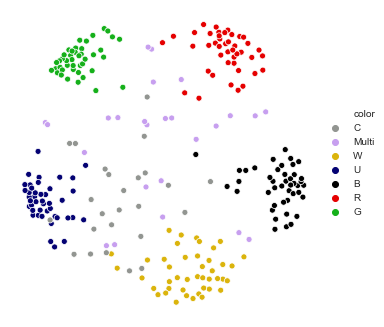

In [397]:
#%matplotlib inline

myPal = sns.xkcd_palette(["grey","lavender","gold","deep blue","black","red","green"])
s = sns.relplot(data=df,x="x",y="y",hue="color",palette=myPal)
s.fig.set_size_inches(6,5)
sns.set_style("white")
s.despine(left=True,bottom=True)
s.set(xticklabels=[],yticklabels=[],xlabel='',ylabel='')

In [398]:
# Save the data.
# Note, it saves to gitHub-visible folder, not to hidden 'data' folder:

df.to_csv('basic_data_'+setName+'.csv', index_label="name")

In [399]:
# Top picks:
df.sort_values(by=['avg'], ascending=True).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
patient_rebuilding,1.0,0.0,719,U,Rare,0,-0.553671,-0.251005,1763
resplendent_angel,1.0,0.0,427,W,Mythic Rare,0,0.339459,-0.536050,1281
chromium_the_mutable,1.0,0.0,344,Multi,Mythic Rare,1,-0.001576,-0.293637,1305
djinn_of_wishes,1.0,0.0,791,U,Rare,0,-0.577254,-0.182429,2184
vivien_reid,1.0,0.0,410,G,Mythic Rare,1,-0.291849,0.498928,1235
demanding_dragon,1.0,0.0,844,R,Rare,0,0.417389,0.567052,2499
prodigious_growth,1.0,0.0,521,G,Rare,0,-0.395285,0.465373,1540
leonin_warleader,1.0,0.0,864,W,Rare,0,0.283631,-0.656366,2423
tezzeret_artifice_master,1.0,0.0,434,U,Mythic Rare,1,-0.507360,-0.096272,1316
lena_selfless_champion,1.0,0.0,660,W,Rare,1,0.169982,-0.589173,1915


In [400]:
# Top controversial cards:
df.sort_values(by=['var'], ascending=False).head(12)

,avg,var,count,color,rarity,legendary,x,y,freq
satyr_enchanter,8.363144,16.353222,2214,Multi,Uncommon,0,-0.268686,0.197202,5844
crucible_of_worlds,8.788732,15.725319,639,C,Mythic Rare,0,-0.121404,-0.099241,1990
scapeshift,10.199253,15.083586,803,G,Mythic Rare,0,-0.197295,0.349445,2645
gigantosaurus,6.248775,14.185797,1837,G,Rare,0,-0.417051,0.374434,4845
omniscience,11.039744,14.161241,780,U,Mythic Rare,0,-0.380302,-0.037476,2628
enigma_drake,5.950339,13.477218,1772,Multi,Uncommon,0,-0.078832,0.163452,6057
desecrated_tomb,9.338362,13.353184,928,C,Rare,0,0.233255,-0.118018,2902
brawl-bash_ogre,5.727423,12.951583,1816,Multi,Uncommon,0,0.504870,0.227418,6477
elvish_clancaller,6.268065,12.832570,858,G,Rare,0,-0.329865,0.332928,2396
doublecast,8.898941,11.673137,1039,R,Uncommon,0,0.244403,0.408927,3589
